# Imports and constants

In [34]:
import numpy as np
import sympy as smp
import warnings
import matplotlib.pyplot as plt
import matplotlib.patches as m_patches
import pandas as pd

from typing import Tuple, Optional, List, Union
from scipy.linalg import null_space

In [35]:
# Geometry
L1 = 0.09
L2 = 0.0424
L3 = 0.0776

X3 = 0.045
Y3 = -0.05
P3 = np.array((X3, Y3))

R = 0.015
W1 = 0.03
W2 = 0.0107
ALPHA = 2.7211

THETA_UPPER_SIM = (49.92 / 180) * np.pi
THETA_LOWER_SIM = (-9.6 / 180) * np.pi

# Physical properties
M1 = 0.1243
M2 = 0.1883
M3 = 0.3445

I1_ZZ = 0.002
I2_ZZ = 0.0018
I3_ZZ = 0.0016

C1_L = 0.0450
C2_L = 0.0535
C3_L = 0.0144
A3_ANGLE = 1.9705

C1 = np.array((C1_L, 0, 0))
C2 = np.array((C2_L, 0, 0))
C3 = np.array((L3 - C3_L * np.cos(A3_ANGLE), -C3_L * np.sin(A3_ANGLE), 0))

G_ACC = 9.80665

# Initial conditions
ANG_ACC_0 = 0.2
ANG_VEL_0 = 0
ANG_0 = -0.16

# Analytical kinematics

In [36]:
time_sym = smp.Symbol('t')
theta_sym = smp.Function(r'\theta')(time_sym)
x_sym, y_sym = smp.symbols('x,y')

circle_1 = smp.Eq(x_sym ** 2 + y_sym ** 2, L1 ** 2)
circle_2 = smp.Eq((x_sym - X3) ** 2 + (y_sym - Y3) ** 2, (L2 + L3) ** 2)

In [37]:
root_1_sym, root_2_sym = smp.solve([circle_1, circle_2], x_sym, y_sym)
x_upper_crit_1_sym, y_upper_crit_1_sym = root_1_sym
x_upper_crit_2_sym, y_upper_crit_2_sym = root_2_sym

In [38]:
x_upper_crit_1_sym = x_upper_crit_1_sym.simplify()
y_upper_crit_1_sym = y_upper_crit_1_sym.simplify()
x_upper_crit_2_sym = x_upper_crit_2_sym.simplify()
y_upper_crit_2_sym = y_upper_crit_2_sym.simplify()

In [39]:
check = x_upper_crit_1_sym > x_upper_crit_2_sym

if check:
    print('We take first root')
    x_upper_crit_sym = x_upper_crit_1_sym
    y_upper_crit_sym = y_upper_crit_1_sym
else:
    print('We take second root')
    x_upper_crit_sym = x_upper_crit_2_sym
    y_upper_crit_sym = y_upper_crit_2_sym

We take second root


In [40]:
theta_upper_crit_sym = smp.atan2(y_upper_crit_sym, x_upper_crit_sym)
theta_upper_crit = float(theta_upper_crit_sym)
print(theta_upper_crit)

0.879939415721041


In [41]:
x_1_sym, y_1_sym = smp.symbols('x_1,y_1')

circle_1 = smp.Eq((x_sym - x_1_sym) ** 2 + (y_sym - y_1_sym) ** 2, L2 ** 2)
circle_2 = smp.Eq((x_sym - X3) ** 2 + (y_sym - Y3) ** 2, L3 ** 2)

In [42]:
root_1_sym, root_2_sym = smp.solve([circle_1, circle_2], x_sym, y_sym)
x_2_1_sym, y_2_1_sym = root_1_sym
x_2_2_sym, y_2_2_sym = root_2_sym

In [43]:
x_2_1_sym = x_2_1_sym.simplify()
y_2_1_sym = y_2_1_sym.simplify()
x_2_2_sym = x_2_2_sym.simplify()
y_2_2_sym = y_2_2_sym.simplify()

In [44]:
check = x_2_1_sym.subs([(x_1_sym, L1), (y_1_sym, 0)]) > x_2_2_sym.subs([(x_1_sym, L1), (y_1_sym, 0)])

if check:
    print('We take first root')
    x_2_sym = x_2_1_sym
    y_2_sym = y_2_1_sym
else:
    print('We take second root')
    x_2_sym = x_2_2_sym
    y_2_sym = y_2_2_sym

We take first root


In [45]:
x_2_sym = x_2_sym.subs([(x_1_sym, L1 * smp.cos(theta_sym)), (y_1_sym, L1 * smp.sin(theta_sym))]).simplify()
y_2_sym = y_2_sym.subs([(x_1_sym, L1 * smp.cos(theta_sym)), (y_1_sym, L1 * smp.sin(theta_sym))]).simplify()

x_1_sym = L1 * smp.cos(theta_sym)
y_1_sym = L1 * smp.sin(theta_sym)

In [46]:
x_1_sym_raw = smp.lambdify([theta_sym], x_1_sym)
y_1_sym_raw = smp.lambdify([theta_sym], y_1_sym)
y_2_sym_raw = smp.lambdify([theta_sym], y_2_sym)
x_2_sym_raw = smp.lambdify([theta_sym], x_2_sym)

In [47]:
def get_first_point(theta: float) -> np.ndarray:
    return np.array((x_1_sym_raw(theta), y_1_sym_raw(theta)))

def get_second_point(theta: float) -> np.ndarray:
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        return np.array((x_2_sym_raw(theta), y_2_sym_raw(theta)))

In [48]:
def get_line_params(p_1: np.ndarray, p_2: np.ndarray) -> Tuple[np.ndarray, float]:
    p_matrix = np.array((np.r_[p_1, -1], np.r_[p_2, -1]))
    n_x, n_y, d = null_space(p_matrix)[:, 0]

    norm_v = np.array((n_x, n_y))
    norm_v /= np.linalg.norm(norm_v)

    if d < 0:
        d = -d
        norm_v = -norm_v

    return norm_v, d

In [49]:
def get_line_a(p_1: np.ndarray, p_2: np.ndarray) -> Tuple[np.ndarray, float]:
    norm_v, d = get_line_params(p_1, p_2)
    return norm_v, d - W1 / 2

def get_line_b(p_1: np.ndarray, p_2: np.ndarray) -> Tuple[np.ndarray, float]:
    rot = np.array([[np.cos(ALPHA), -np.sin(ALPHA)],
                    [np.sin(ALPHA), np.cos(ALPHA)]])
    p_2_p_1 = p_2 - p_1
    p_2_p_1 = rot.dot(p_2_p_1)
    norm_v, d = get_line_params(p_1, p_1 + p_2_p_1)
    return norm_v, d - W2 / 2

In [50]:
D_THETA = 0.001

def find_lower_crit_theta() -> Optional[float]:
    c_theta = 0
    while c_theta > -2 * np.pi:
        p_1 = get_first_point(c_theta)
        p_2 = get_second_point(c_theta)

        if np.isnan(p_1).any() or np.isnan(p_2).any():
            return c_theta

        norm_a, d_a = get_line_a(P3, p_2)
        norm_b, d_b = get_line_b(P3, p_2)

        if norm_a.dot(p_1 - norm_a * d_a) >= -R:
            return c_theta
        if norm_b.dot(-norm_b * d_b) >= -R:
            return c_theta

        c_theta -= D_THETA
    return None

In [51]:
theta_lower_crit = find_lower_crit_theta()
print(theta_lower_crit)

-0.16200000000000012


In [52]:
%matplotlib inline

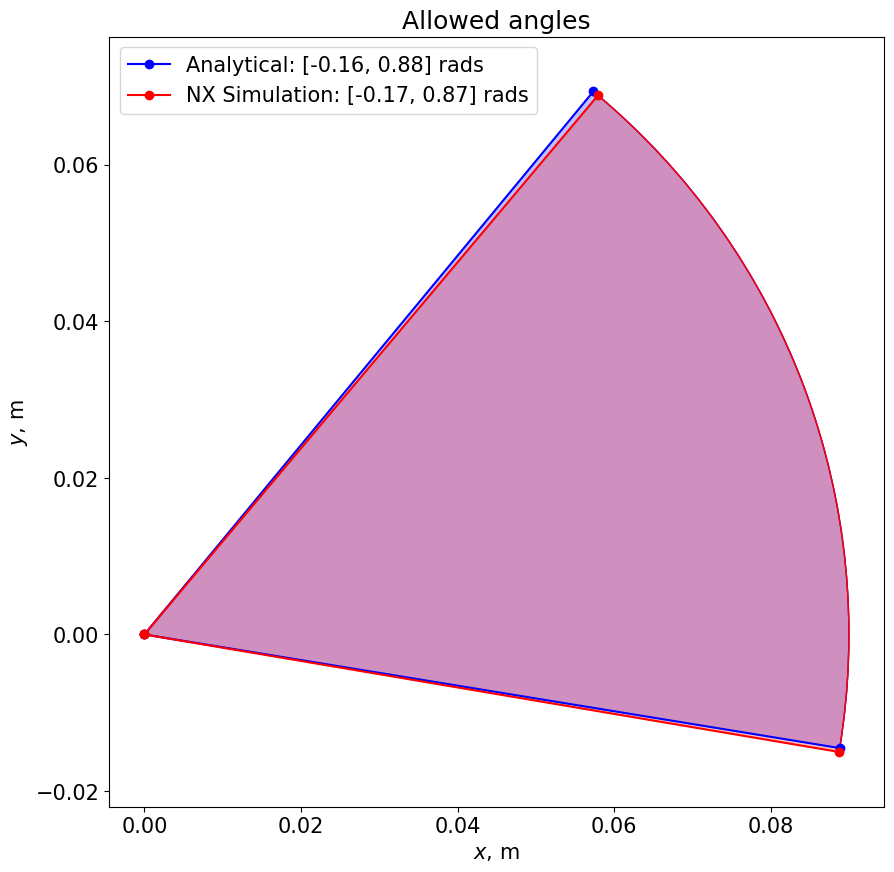

In [53]:
def arc_filled(center: Union[List[float], np.ndarray],
               radius: float, theta_1: float, theta_2: float,
               ax=None, resolution: int = 50, **kwargs):
    if ax is None:
        ax = plt.gca()

    theta = np.linspace(theta_1, theta_2, resolution)
    points = np.vstack((radius*np.cos(theta) + center[0],
                        radius*np.sin(theta) + center[1]))
    points = np.c_[points, [0, 0]]
    poly = m_patches.Polygon(points.T, closed=True, **kwargs)
    ax.add_patch(poly)
    return poly


def arc_path(center: Union[List[float], np.ndarray],
             radius: float, theta_1: float, theta_2: float,
             ax=None, **kwargs):
    if ax is None:
        ax = plt.gca()

    theta_1 = 180 * (theta_1 / np.pi)
    theta_2 = 180 * (theta_2 / np.pi)
    arc = m_patches.Arc(tuple(center), 2 * radius, 2 * radius, theta1=theta_1, theta2=theta_2, **kwargs)
    ax.add_patch(arc)
    return arc


def plot_angle(center: Union[List[float], np.ndarray], radius: float,
               theta_1: float, theta_2: float, color: str,
               ax, **kwargs):
    c_x, c_y = center
    ax.plot([c_x, radius * np.cos(theta_1)], [c_y, radius * np.sin(theta_1)],
            marker='o', color=color, label=kwargs.get('label', None))
    ax.plot([c_x, radius * np.cos(theta_2)], [c_y, radius * np.sin(theta_2)],
            marker='o', color=color)

    arc_filled([0, 0], L1, theta_1, theta_2, ax=ax, color=color, alpha=kwargs.get('alpha', 0.25))
    arc_path([0, 0], L1, theta_1, theta_2, ax=ax, color=color)

def compare_via_pie_chart():
    plt.rcParams.update({'font.size': 15})
    plt.figure(figsize=(10, 10))
    plt.title('Allowed angles')
    plt.axis('equal')

    ax = plt.gca()
    plot_angle([0, 0], L1, theta_lower_crit, theta_upper_crit, 'b', ax,
               label=f'Analytical: [{theta_lower_crit:.2f}, {theta_upper_crit:.2f}] rads')
    plot_angle([0, 0], L1, THETA_LOWER_SIM, THETA_UPPER_SIM, 'r', ax,
               label=f'NX Simulation: [{THETA_LOWER_SIM:.2f}, {THETA_UPPER_SIM:.2f}] rads')

    plt.xlabel('$x$, m')
    plt.ylabel('$y$, m')
    plt.legend(loc='best')
    plt.show()

compare_via_pie_chart()

# Analytical dynamics

In [54]:
x_1_f_sym = smp.Function('x_1')(theta_sym)
y_1_f_sym = smp.Function('y_1')(theta_sym)
x_2_f_sym = smp.Function('x_2')(theta_sym)
y_2_f_sym = smp.Function('y_2')(theta_sym)

rot_1_sym = smp.Matrix(
    [
        [smp.cos(theta_sym), -smp.sin(theta_sym), 0],
        [smp.sin(theta_sym), smp.cos(theta_sym), 0],
        [0, 0, 1]
    ]
)
rot_2_sym = smp.Matrix(
    [
        [(x_2_f_sym - x_1_f_sym) / L2, (y_1_f_sym - y_2_f_sym) / L2, 0],
        [(y_2_f_sym - y_1_f_sym) / L2, (x_2_f_sym - x_1_f_sym) / L2, 0],
        [0, 0, 1]
    ]
)
rot_3_sym = smp.Matrix(
    [
        [(X3 - x_2_f_sym) / L3, (y_2_f_sym - Y3) / L3, 0],
        [(Y3 - y_2_f_sym) / L3, (X3 - x_2_f_sym) / L3, 0],
        [0, 0, 1]
    ]
)
rot_2_sym.simplify()
rot_3_sym.simplify()

In [55]:
dot_rot_2_sym = rot_2_sym.diff(time_sym)
dot_rot_3_sym = rot_3_sym.diff(time_sym)
dot_rot_2_sym.simplify()
dot_rot_3_sym.simplify()

In [56]:
omega_2_sym = smp.Matrix([0, 0, (dot_rot_2_sym * rot_2_sym.transpose())[1,0]])
omega_3_sym = smp.Matrix([0, 0, (dot_rot_3_sym * rot_3_sym.transpose())[1,0]])
omega_2_sym.simplify()
omega_3_sym.simplify()

In [57]:
omega_1_sym = smp.Matrix([0, 0, theta_sym.diff(time_sym)])
vel_1_sym = omega_1_sym.cross(rot_1_sym * smp.Matrix(C1))
vel_2_sym = smp.Matrix([x_1_f_sym.diff(time_sym), y_1_f_sym.diff(time_sym), 0]) + omega_2_sym.cross(rot_2_sym * smp.Matrix(C2))
vel_3_sym = smp.Matrix([x_2_f_sym.diff(time_sym), y_2_f_sym.diff(time_sym), 0]) + omega_3_sym.cross(rot_3_sym * smp.Matrix(C3))

vel_1_sym.simplify()
vel_2_sym.simplify()
vel_3_sym.simplify()

In [58]:
c1_sym = rot_1_sym * smp.Matrix(C1)
c2_sym = smp.Matrix([x_1_f_sym, y_1_f_sym, 0]) + rot_2_sym * smp.Matrix(C2)
c3_sym = smp.Matrix([x_2_f_sym, y_2_f_sym, 0]) + rot_3_sym * smp.Matrix(C3)

c1_sym.simplify()
c2_sym.simplify()
c3_sym.simplify()

In [59]:
T_sym = smp.simplify(
    M1 * vel_1_sym.transpose() * vel_1_sym +
    M2 * vel_2_sym.transpose() * vel_2_sym +
    M3 * vel_3_sym.transpose() * vel_3_sym
) / 2
T_sym += smp.simplify(
    I1_ZZ * omega_1_sym.transpose() * omega_1_sym +
    I2_ZZ * omega_2_sym.transpose() * omega_2_sym +
    I3_ZZ * omega_3_sym.transpose() * omega_3_sym
) / 2
T_sym = T_sym[0,0]

P_sym = ((M1 * c1_sym + M2 * c2_sym + M3 * c3_sym) * G_ACC)[1,0]

T_sym = T_sym.simplify()
P_sym = P_sym.simplify()

In [60]:
L_sym = T_sym - P_sym

In [61]:
left_L_sym = L_sym.diff(theta_sym.diff(time_sym)).diff(time_sym)
right_L_sym = L_sym.diff(theta_sym)
overall_L_sym = left_L_sym - right_L_sym

In [62]:
x_1_sym_over_theta_raw = smp.lambdify([theta_sym], x_1_sym.diff(theta_sym))
y_1_sym_over_theta_raw = smp.lambdify([theta_sym], y_1_sym.diff(theta_sym))
x_2_sym_over_theta_raw = smp.lambdify([theta_sym], x_2_sym.diff(theta_sym))
y_2_sym_over_theta_raw = smp.lambdify([theta_sym], y_2_sym.diff(theta_sym))

x_1_sym_over_theta_2_raw = smp.lambdify([theta_sym], x_1_sym.diff(theta_sym).diff(theta_sym))
y_1_sym_over_theta_2_raw = smp.lambdify([theta_sym], y_1_sym.diff(theta_sym).diff(theta_sym))
x_2_sym_over_theta_2_raw = smp.lambdify([theta_sym], x_2_sym.diff(theta_sym).diff(theta_sym))
y_2_sym_over_theta_2_raw = smp.lambdify([theta_sym], y_2_sym.diff(theta_sym).diff(theta_sym))

def get_first_over_theta(theta: float) -> np.ndarray:
    return np.array(
        [
            x_1_sym_over_theta_raw(theta),
            y_1_sym_over_theta_raw(theta)
        ]
    )

def get_second_over_theta(theta: float) -> np.ndarray:
    return np.array(
        [
            x_2_sym_over_theta_raw(theta),
            y_2_sym_over_theta_raw(theta)
        ]
    )

def get_first_over_theta_2(theta: float) -> np.ndarray:
    return np.array(
        [
            x_1_sym_over_theta_2_raw(theta),
            y_1_sym_over_theta_2_raw(theta)
        ]
    )

def get_second_over_theta_2(theta: float) -> np.ndarray:
    return np.array(
        [
            x_2_sym_over_theta_2_raw(theta),
            y_2_sym_over_theta_2_raw(theta)
        ]
    )

In [63]:
overall_L_sym_raw = smp.lambdify(
    [
        theta_sym, theta_sym.diff(time_sym), theta_sym.diff(time_sym).diff(time_sym),
        x_1_f_sym, y_1_f_sym, x_2_f_sym, y_2_f_sym,
        x_1_f_sym.diff(theta_sym), y_1_f_sym.diff(theta_sym), x_2_f_sym.diff(theta_sym), y_2_f_sym.diff(theta_sym),
        x_1_f_sym.diff(theta_sym).diff(theta_sym), y_1_f_sym.diff(theta_sym).diff(theta_sym),
        x_2_f_sym.diff(theta_sym).diff(theta_sym), y_2_f_sym.diff(theta_sym).diff(theta_sym),
    ],
    overall_L_sym
)

def get_overall_lagrange(theta: float, theta_dot: float, theta_ddot: float) -> float:
    return overall_L_sym_raw(
        theta, theta_dot, theta_ddot,
        *get_first_point(theta), *get_second_point(theta),
        *get_first_over_theta(theta), *get_second_over_theta(theta),
        *get_first_over_theta_2(theta), *get_second_over_theta_2(theta)
    )

# Comparison

In [64]:
def load_nx_data(path: str, col: int = 1) -> np.ndarray:
    data = pd.read_csv(path, header=1)
    return data[data.columns[col]].to_numpy(dtype=float)

def compute_analytical(timestamps: np.ndarray) -> np.ndarray:
    theta_val = ANG_0
    torques = []
    for time_val in timestamps:
        torques.append(
            get_overall_lagrange(
                theta_val + ANG_VEL_0 * time_val + (ANG_ACC_0 / 2) * time_val ** 2,
                ANG_VEL_0 + ANG_ACC_0 * time_val,
                ANG_ACC_0
            )
        )
    return np.array(torques)

torque_vals_nx = load_nx_data('torque.csv')
time_vals_nx = load_nx_data('torque.csv', col=0)
torque_vals = compute_analytical(time_vals_nx)

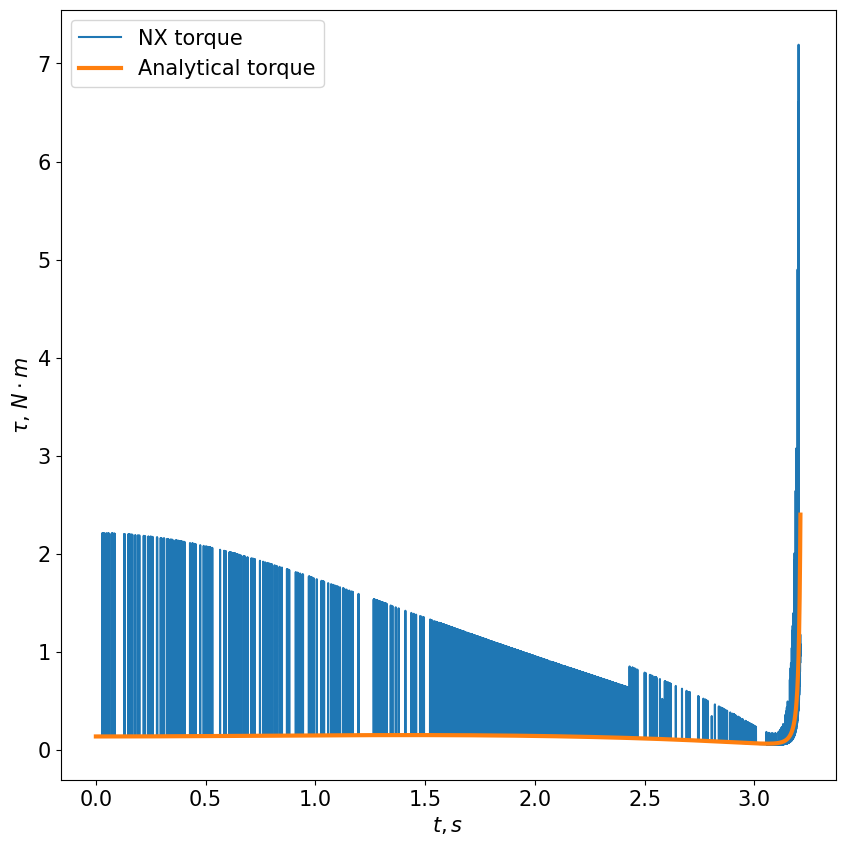

In [65]:
plt.figure(figsize=(10, 10))
plt.plot(time_vals_nx, torque_vals_nx, label='NX torque')
plt.plot(time_vals_nx, torque_vals, label='Analytical torque', linewidth=3)
plt.xlabel('$t,s$')
plt.ylabel(r'$\tau$, $N \cdot m$')
plt.legend(loc='best')
plt.show()

In [68]:
print('STD:', np.std(torque_vals_nx - torque_vals))

STD: 0.33935734516312654
